In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [115]:
loops = range(0,21)
phases = range(0,4)

data_directory = r'C:\Users\fenklab\Desktop\Smooth Tracking Entry\Cleaned Data'
plot_directory = r'C:\Users\fenklab\Desktop\Smooth Tracking Entry\Plot'
output_files = os.listdir(data_directory)

fly_ids = set()
# Iterate through the list and extract the fly's IDs
for item in output_files:
    id = '_'.join(item.split('_')[:-1])
    fly_ids.add(id)

df_Stimulus = {}
df_LE = {}
df_RE = {}
df_Log = {}

# Load each CSV file into a dataframe and add it to the dictionary with the file name as the key
for fly in fly_ids:
    print(fly)
    path = os.path.join(data_directory, fly)
    df_Stimulus[fly] = pd.read_csv(path + '_Stimulus.csv')
    df_RE[fly] = pd.read_csv(path + '_RE.csv')
    df_LE[fly] = pd.read_csv(path + '_LE.csv')
    df_Log[fly] = pd.read_csv(path + '_Log.csv')

CS0201_1
CS0201_6
Suzuki1001_5
Suzuki1001_4
Suzuki0901_3
Suzuki1001_3
Suzuki1701_5
Suzuki0901_4
CS0201_4
CS0201_5
Yakuba1901_1
Suzuki0901_1
Yakuba1901_6
CS0301_1
Yakuba1901_4
Yakuba1901_3
Suzuki1001_1
CS0201_3
Yakuba1801_1


# For each species, get the mean Pixel/Ommatidium Ratio and convert the tracking units in ommatidia units

In [116]:
species_dic = {'CS':
           {'omm_limit':[-1, 1]},
           'Suzuki':
           {'omm_limit':[-0.5, 0.5]},
           'Yakuba':
           {'omm_limit':[-0.5, 0.5]}}

def Get_Tracking_in_Ommatidia_Mean(IDs):
    species_Log = [df_Log[fly] for fly in IDs]
    concatenated_species_log = pd.concat(species_Log, ignore_index=True)
    mean_species_PixOmm_ratio_Left = concatenated_species_log['Left_PixelOmmatidiaRatio'].mean()
    mean_species_PixOmm_ratio_Right = concatenated_species_log['Right_PixelOmmatidiaRatio'].mean()
    
    for fly in IDs:
        df_LE[fly]['omm_x'] = df_LE[fly]['pix_x']/mean_species_PixOmm_ratio_Left
        df_LE[fly]['omm_y'] = df_LE[fly]['pix_y']/mean_species_PixOmm_ratio_Left
    
        df_RE[fly]['omm_x'] = df_RE[fly]['pix_x']/mean_species_PixOmm_ratio_Right
        df_RE[fly]['omm_y'] = df_RE[fly]['pix_y']/mean_species_PixOmm_ratio_Right

for species in [*species_dic]:
    species_dic[species]['IDs'] = [fly for fly in fly_ids if species in fly]
    Get_Tracking_in_Ommatidia_Mean(species_dic[species]['IDs'])

# Get a loop that goes over and give me the plots+saves them

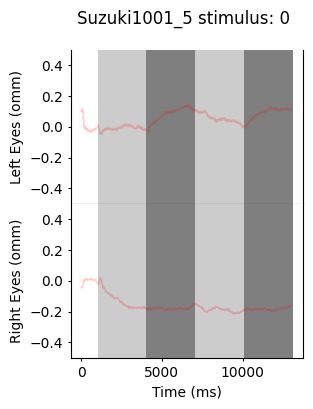

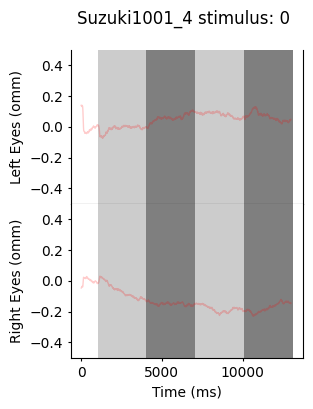

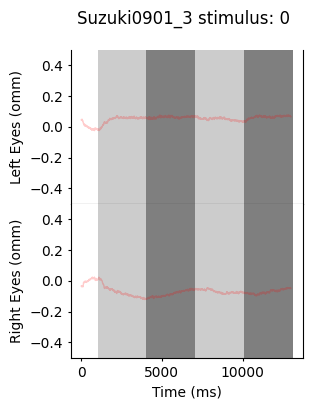

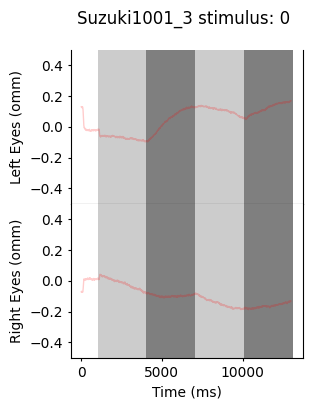

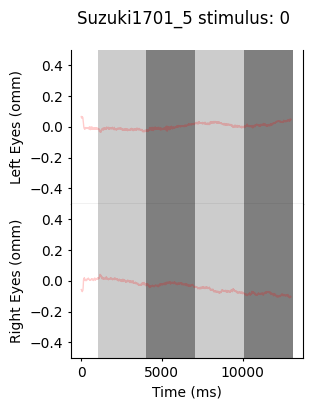

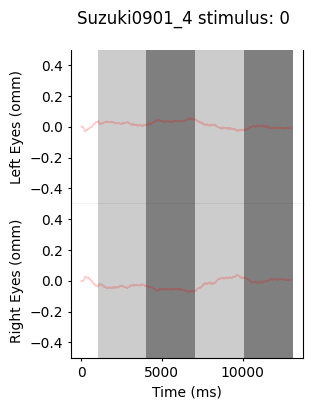

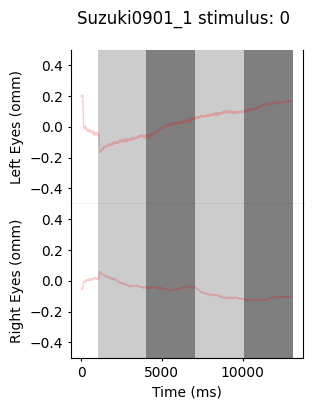

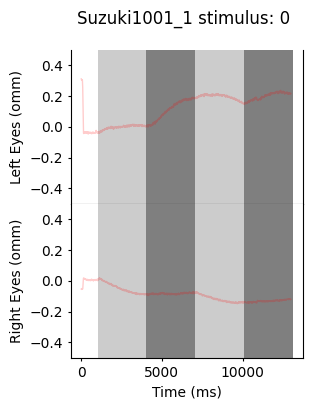

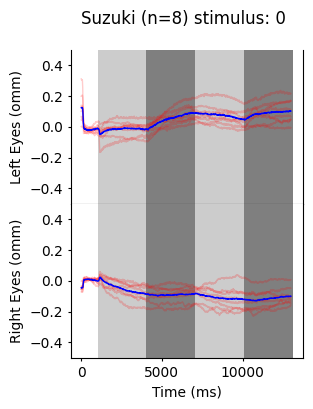

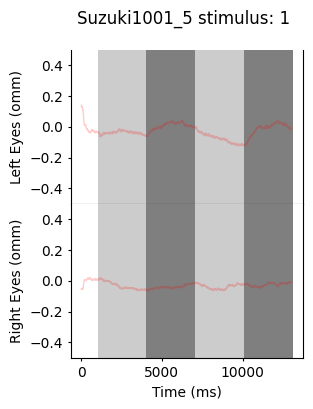

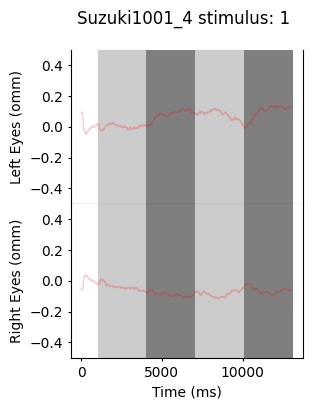

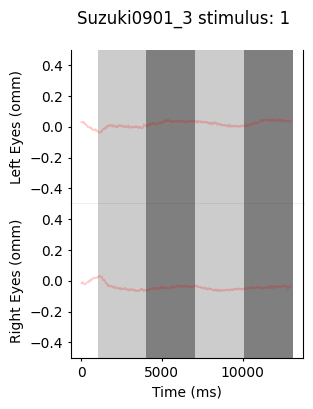

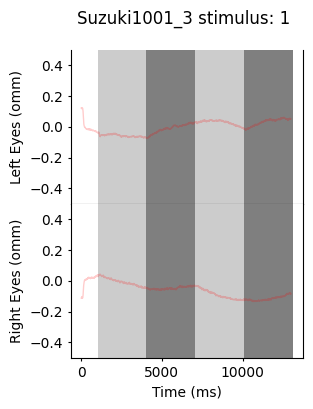

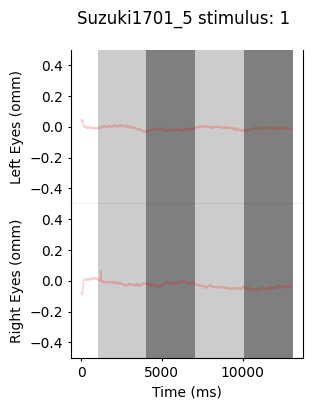

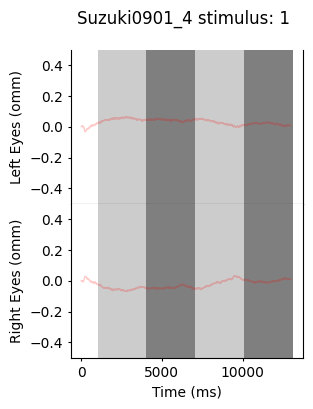

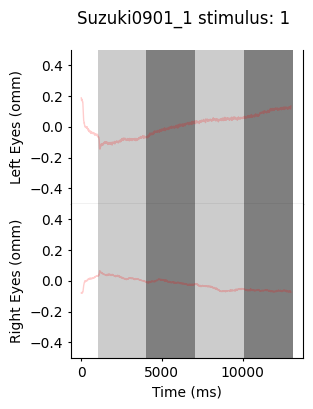

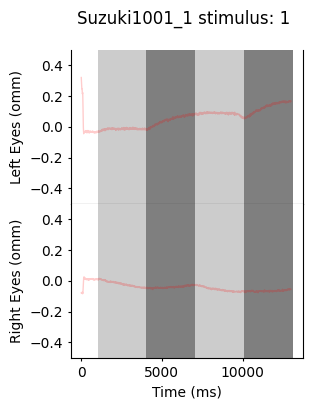

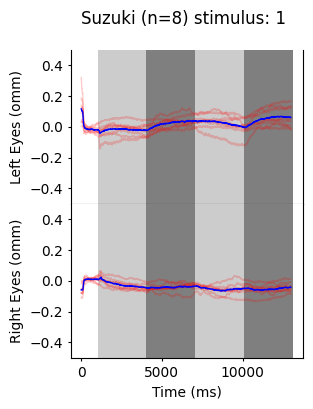

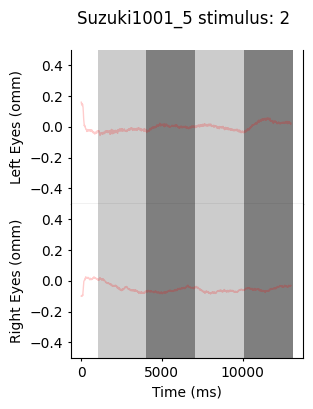

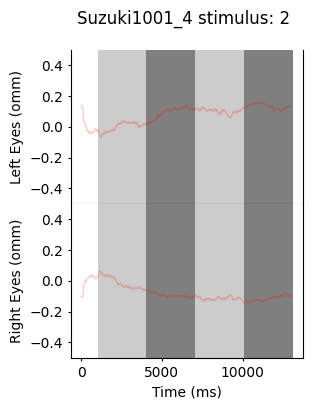

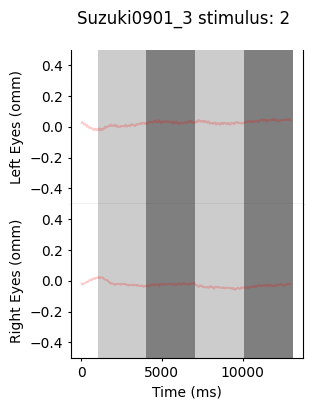

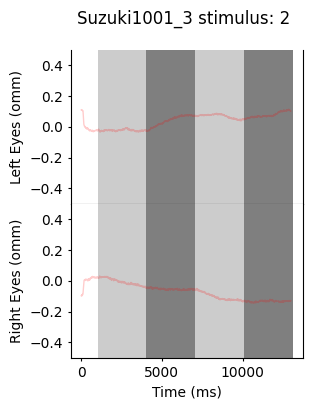

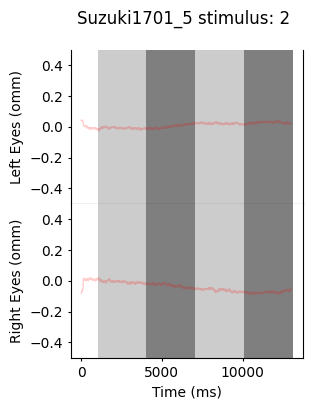

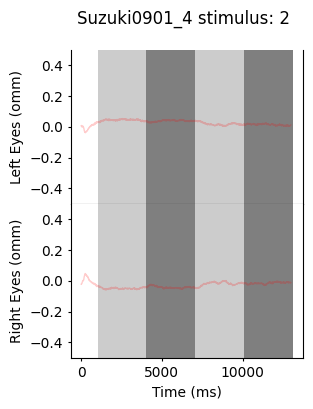

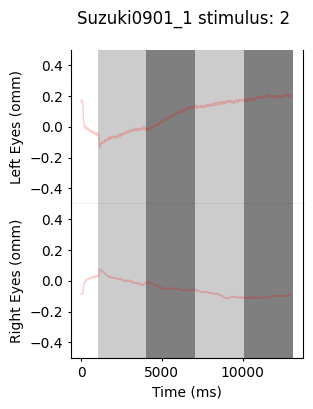

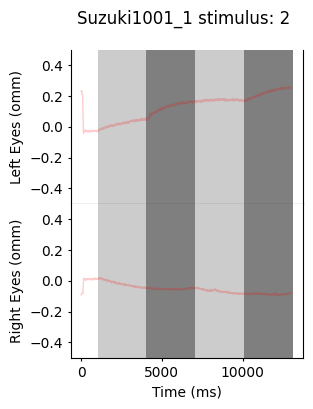

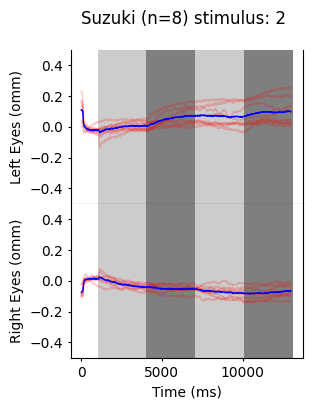

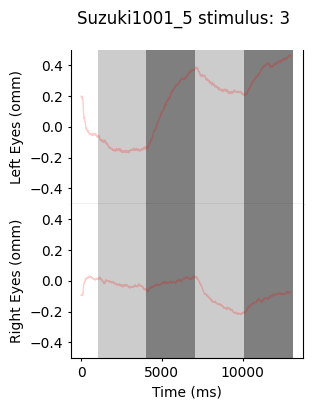

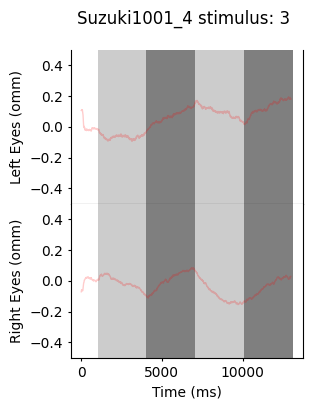

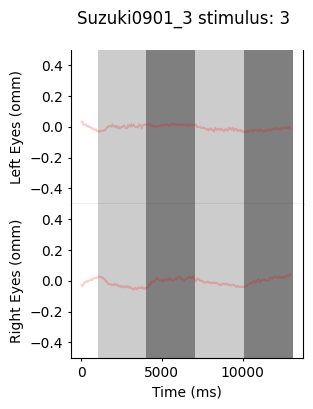

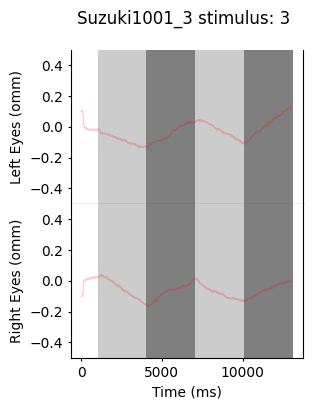

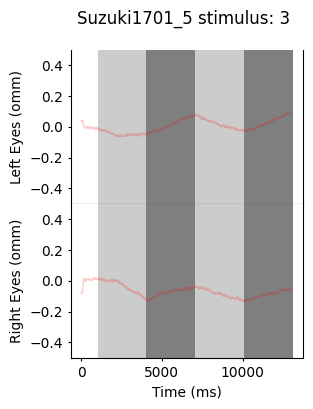

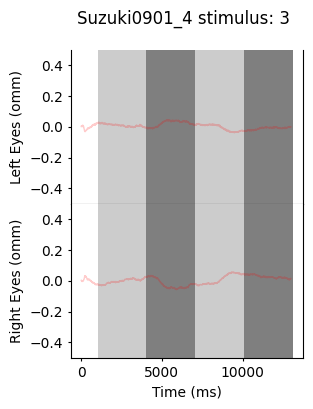

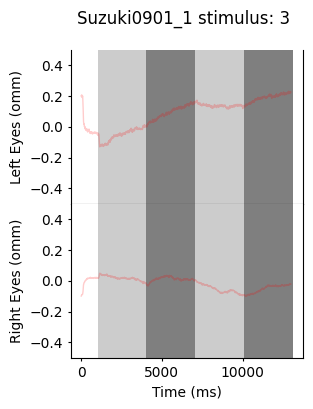

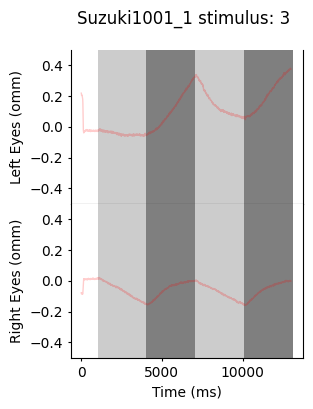

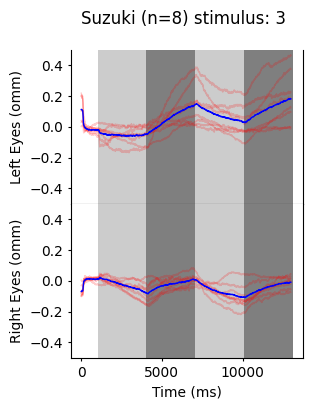

In [121]:
focused_species = 'Suzuki'
focused_flies = species_dic[focused_species]['IDs']
#focused_flies = ["Yakuba1901_3"]

intervals = 10
ylim = species_dic[focused_species]['omm_limit']
axes = ['omm_x']
save = True

merged_df_Stimulus = pd.concat([df_Stimulus[fly] for fly in focused_flies], ignore_index=True)
mean_time_sides = merged_df_Stimulus.groupby(['Event', 'ID', 'Parent_phase']).agg({'Start_ms': 'mean', 'End_ms': 'mean'}).reset_index()
mean_time_phases = merged_df_Stimulus[merged_df_Stimulus['Event'] == 'phase'].groupby(['ID']).agg({'Start_ms': 'mean', 'End_ms': 'mean'}).reset_index()

def config_PhaseMean_subplot(subplot, phase, ylabel=None, xlabel=None, xlim=None, ylim = None):
    subplot.set_ylabel(ylabel)
    subplot.tick_params(axis='y')
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(True)
    subplot.spines['left'].set_visible(True)
    subplot.tick_params(axis='both', which='both', length=2)
    if xlabel is not None: subplot.set_xlabel(xlabel)
    if ylim is not None: subplot.set_ylim(ylim[0], ylim[1])
    if xlim is not None: subplot.set_xlim(xlim[0], xlim[1])
        
    start_phase = mean_time_phases[mean_time_phases['ID'] == phase]['Start_ms'].iloc[0]
    for index, row in mean_time_sides.iterrows():
        if row['Parent_phase'] == phase:
            alpha = 0.2 if row['ID']%2 == 0 else 0.5
            mean_start_side = (row['Start_ms']-start_phase)
            mean_end_side = (row['End_ms']-start_phase)
            subplot.axvspan(mean_start_side, mean_end_side, facecolor='0', alpha=alpha, zorder=-100)

def get_interpolated_values(df, df_Stimulus, new_time_stimuli, time_axis, pos_axes):
        
    times = df[time_axis].values
    if (times.min() > new_time_stimuli.max()) | (times.max() < new_time_stimuli.min()):
        print('new ticks outside of Data range')
        return pd.DataFrame()

    # Find the indices where each event time would be inserted to maintain sorted order
    indices = np.clip(np.searchsorted(times, new_time_stimuli), 1, len(times) - 1)

    # Calculate time distances
    delta_t = new_time_stimuli - times[indices - 1]
    delta_times = times[indices] - times[indices - 1]
    
    new_values = {}
    
    # Calculate the linearly interpolated values
    for axis in pos_axes:
        positions = df[axis].values
        delta_positions = positions[indices] - positions[indices - 1]
        interpolated_positions = positions[indices - 1] + (delta_positions / delta_times) * delta_t
        new_values[axis] = interpolated_positions
        
    interpolated_df = pd.DataFrame(new_values)
    interpolated_df.insert(0, time_axis, new_time_stimuli)
   
    return interpolated_df

# create time intervals for each phase's instance and give it an linearly extrapolated omm_x value
resampled_df_LE = {}
resampled_df_RE = {}
for fly in focused_flies:
    
    stimulus = df_Stimulus[fly]
    concat_phases_LE = dict.fromkeys(phases, pd.DataFrame())
    concat_phases_RE = dict.fromkeys(phases, pd.DataFrame())
    
    for loop in loops:
        loop_concerned_LE = df_LE[fly][df_LE[fly]['stimuli_loop'] == loop]
        loop_concerned_RE = df_RE[fly][df_RE[fly]['stimuli_loop'] == loop]
        loop_concerned_stimulus = stimulus[stimulus['Parent_loop'] == loop]
        
        for phase in phases:
            phase_data = loop_concerned_stimulus[(loop_concerned_stimulus['Event'] == 'phase') & (loop_concerned_stimulus['ID'] == phase)].iloc[0]
            new_tick_phase = np.arange(0, phase_data['Duration'].astype(int)*1000, intervals)
            side_start = loop_concerned_stimulus[(loop_concerned_stimulus['Parent_phase'] == phase) & (loop_concerned_stimulus['ID'] == 0)].iloc[0]['Start_ms'] - phase_data['Start_ms']
    
            concerned_LE = loop_concerned_LE[loop_concerned_LE['stimuli_phase'] == phase]
            if not concerned_LE.empty: 
                resampled_df_LE = get_interpolated_values(concerned_LE, stimulus, new_tick_phase, 'time_phase', axes)
                resampled_df_LE['omm_x'] -= resampled_df_LE.loc[resampled_df_LE['time_phase'] < side_start, 'omm_x'].mean()
                concat_phases_LE[phase] = pd.concat([concat_phases_LE[phase], resampled_df_LE], ignore_index=True) #add the interpolated value of the unique phase to a dataframe specific for the phase ID
    
            concerned_RE = loop_concerned_RE[loop_concerned_RE['stimuli_phase'] == phase]
            if not concerned_LE.empty: 
                resampled_df_RE = get_interpolated_values(concerned_RE, stimulus, new_tick_phase, 'time_phase', axes)
                resampled_df_RE['omm_x'] -= resampled_df_RE.loc[resampled_df_RE['time_phase'] < side_start, 'omm_x'].mean()
                concat_phases_RE[phase] = pd.concat([concat_phases_RE[phase], resampled_df_RE], ignore_index=True) #add the interpolated value of the unique phase to a dataframe specific for the phase ID

    interpolated_df_LE[fly] = concat_phases_LE
    interpolated_df_RE[fly] = concat_phases_RE


means_LE = pd.DataFrame()
means_RE = pd.DataFrame()

#concat together each identical stimulus phases for all flies
for fly in focused_flies:
    for phase in phases:
        fly_phase_mean_LE = interpolated_df_LE[fly][phase].groupby('time_phase')['omm_x'].mean().reset_index()
        fly_phase_mean_LE['Fly'] = fly
        fly_phase_mean_LE['phase'] = phase
        means_LE = pd.concat([means_LE, fly_phase_mean_LE], ignore_index=True)

        fly_phase_mean_RE = interpolated_df_RE[fly][phase].groupby('time_phase')['omm_x'].mean().reset_index()
        fly_phase_mean_RE['Fly'] = fly
        fly_phase_mean_RE['phase'] = phase
        means_RE = pd.concat([means_RE, fly_phase_mean_RE], ignore_index=True)        

# For each phase, plot individuals means and pop's mean line 
for phase in phases:
    phase_concerned_LE = means_LE[means_LE['phase'] == phase]
    phase_concerned_RE = means_RE[means_LE['phase'] == phase]

    #individually plot each fly's mean line for the phase
    for fly in focused_flies:
        fig, axs = plt.subplots(2, 1, figsize=(3, 4), sharex=False)
        i=0
        config_PhaseMean_subplot(axs[i], phase, ylabel='Left Eyes (omm)', xlabel='Time (ms)', ylim=ylim)
        plot_data = phase_concerned_LE[phase_concerned_LE['Fly'] == fly]
        axs[i].plot(plot_data['time_phase'], plot_data['omm_x'], label='Mean Position', color='red', linewidth=1, alpha=0.2)
        i=1
        config_PhaseMean_subplot(axs[i], phase, ylabel='Right Eyes (omm)', xlabel='Time (ms)', ylim=ylim)
        plot_data = phase_concerned_RE[phase_concerned_RE['Fly'] == fly]
        axs[i].plot(plot_data['time_phase'], plot_data['omm_x'], label='Mean Position', color='red', linewidth=1, alpha=0.2)
    
        plt.suptitle(f'{fly} stimulus: {phase}') # Set title for the entire figure
        plt.subplots_adjust(hspace=0)     # Adjust spacing between subplots
        if(save):
            plt.savefig(os.path.join(plot_directory,f'{fly}_Mean_stimulus{phase}.png'), format='png')
        plt.show()

    #plot togteher each fly's left and right eye mean as well as the pop mean
    fig, axs = plt.subplots(2, 1, figsize=(3, 4), sharex=False)
    i=0
    config_PhaseMean_subplot(axs[i], phase, ylabel='Left Eyes (omm)', xlabel='Time (ms)', ylim=ylim)
    for fly in focused_flies: #plot each fly's left and right eye mean for the phase
        plot_data = phase_concerned_LE[phase_concerned_LE['Fly'] == fly]
        axs[i].plot(plot_data['time_phase'], plot_data['omm_x'], label='Mean Position', color='red', linewidth=1, alpha=0.2)
    phase_pop_means_LE = phase_concerned_LE.groupby('time_phase')['omm_x'].mean().reset_index()
    axs[i].plot(phase_pop_means_LE['time_phase'], phase_pop_means_LE['omm_x'], label='Mean Position', color='blue', linewidth=1)

    i=1
    config_PhaseMean_subplot(axs[i], phase, ylabel='Right Eyes (omm)', xlabel='Time (ms)', ylim=ylim)
    for fly in focused_flies: #plot each fly's right eye mean for the phase
        plot_data = phase_concerned_RE[phase_concerned_RE['Fly'] == fly]
        axs[i].plot(plot_data['time_phase'], plot_data['omm_x'], label='Mean Position', color='red', linewidth=1, alpha=0.2)
    phase_pop_means_RE = phase_concerned_RE.groupby('time_phase')['omm_x'].mean().reset_index()
    axs[i].plot(phase_pop_means_RE['time_phase'], phase_pop_means_RE['omm_x'], label='Mean Position', color='blue', linewidth=1)
    
    plt.suptitle(f'{focused_species} (n={len(focused_flies)}) stimulus: {phase}') # Set title for the entire figure
    plt.subplots_adjust(hspace=0)     # Adjust spacing between subplots
    if(save):
        plt.savefig(os.path.join(plot_directory,f'{focused_species}_Mean_stimulus{phase}.png'), format='png')
    plt.show()

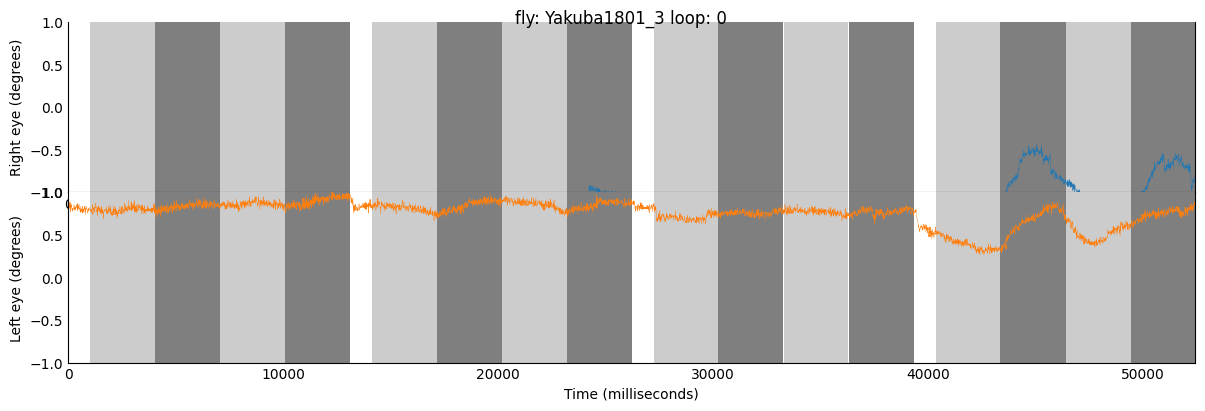

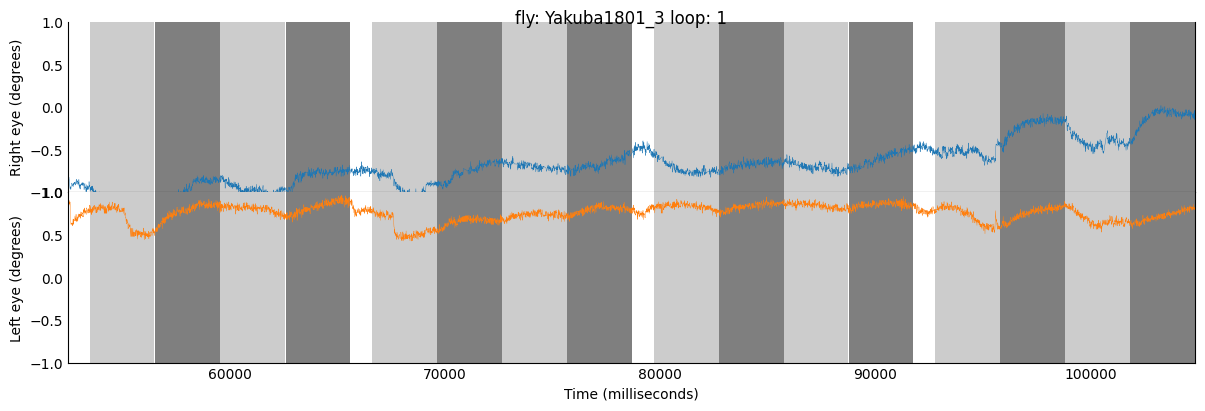

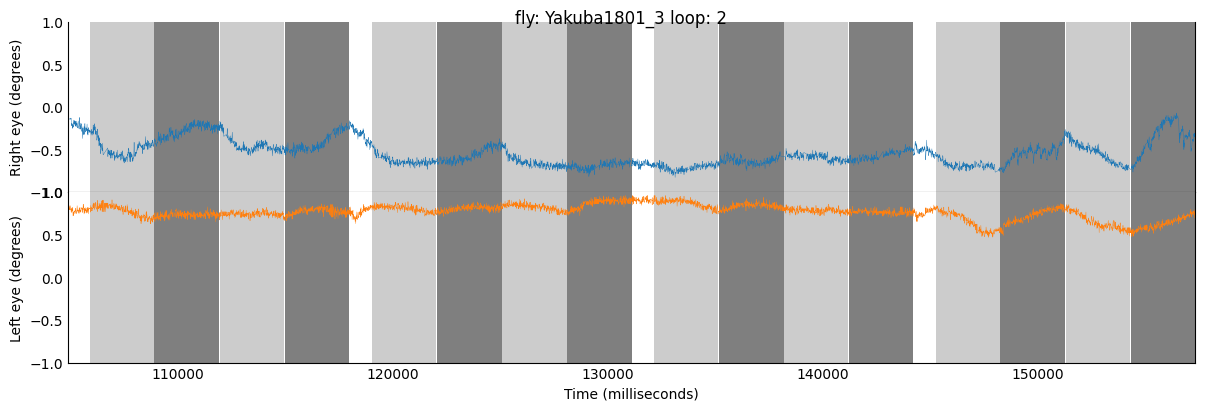

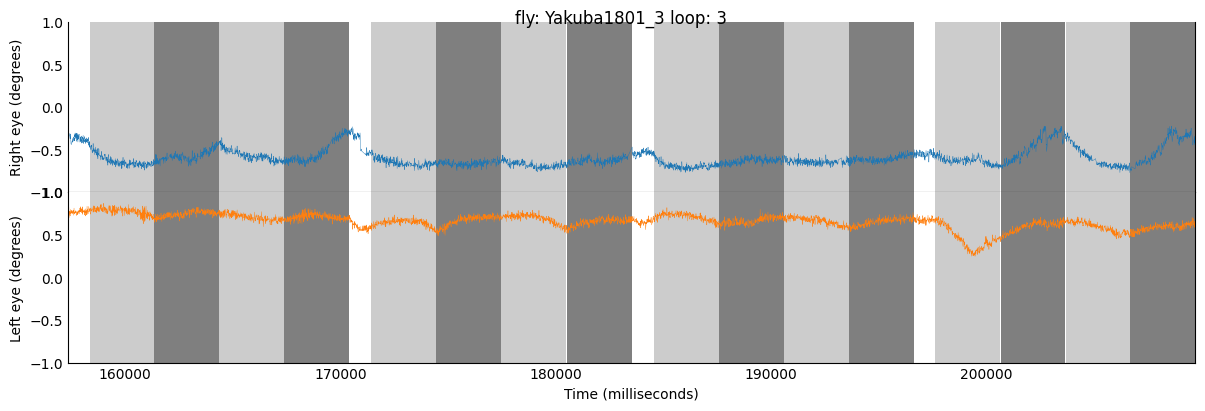

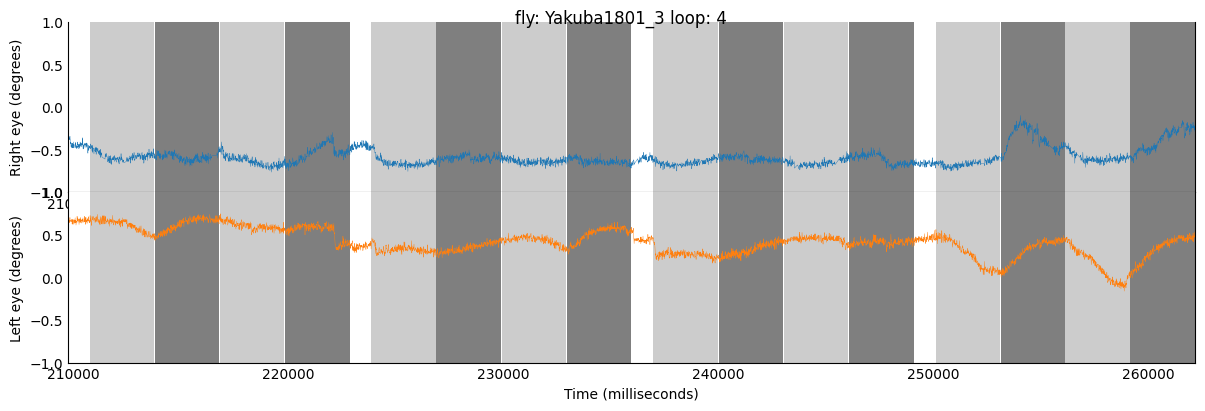

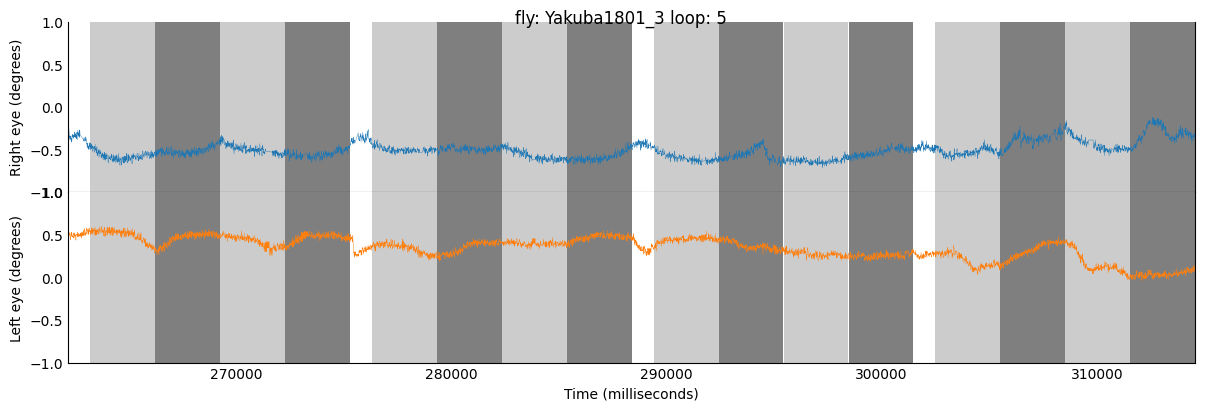

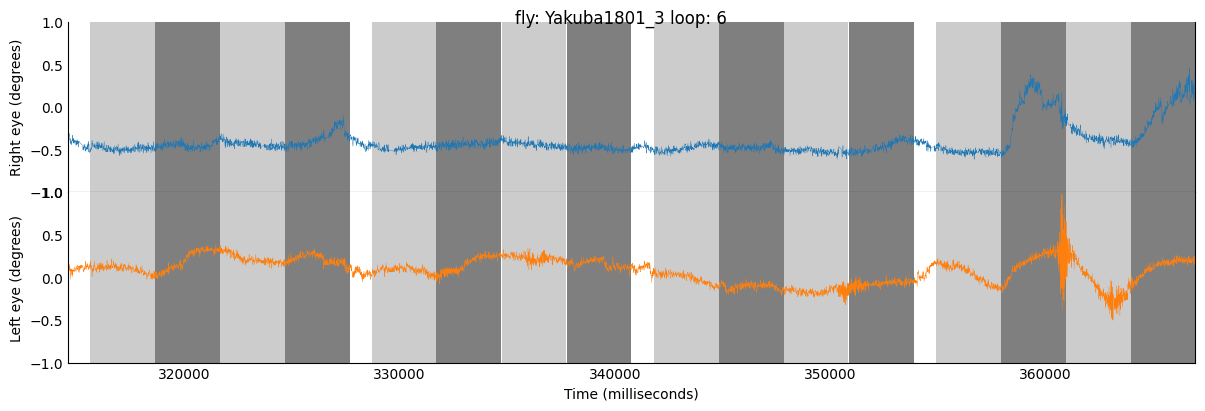

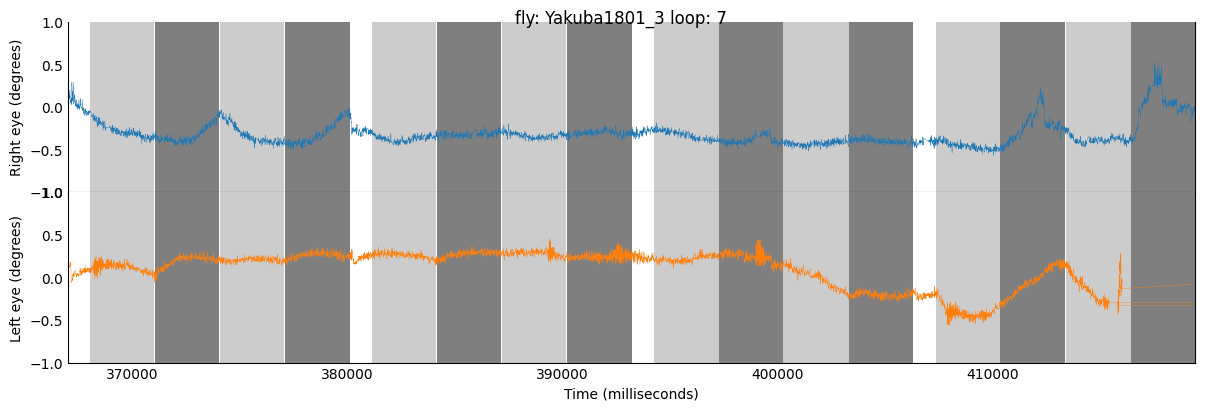

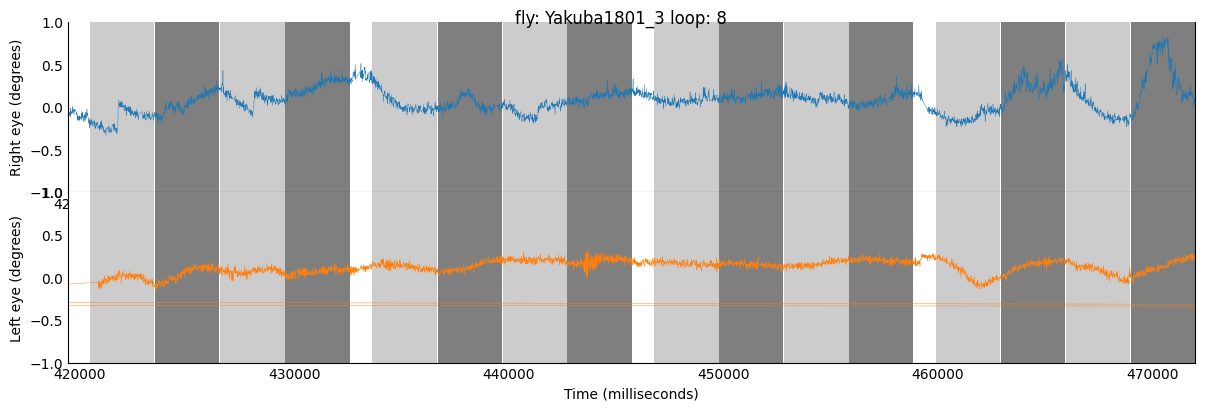

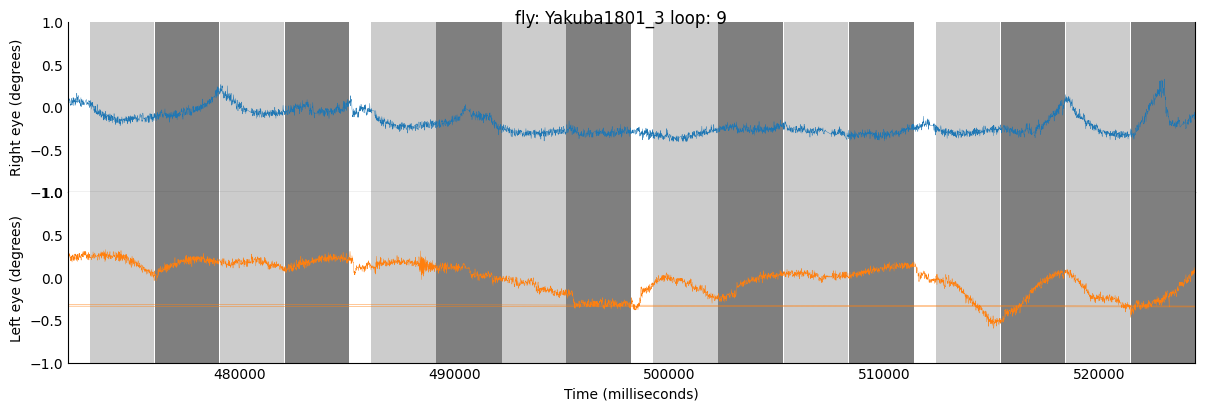

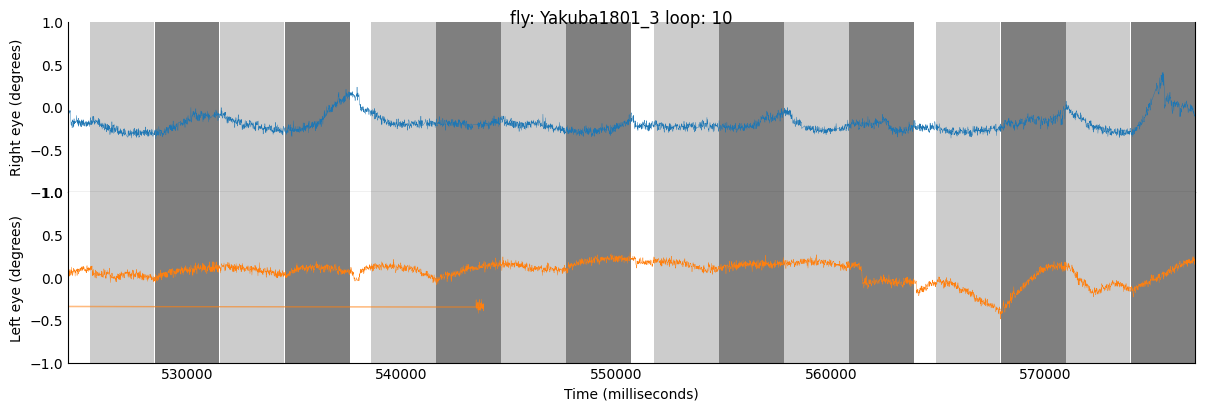

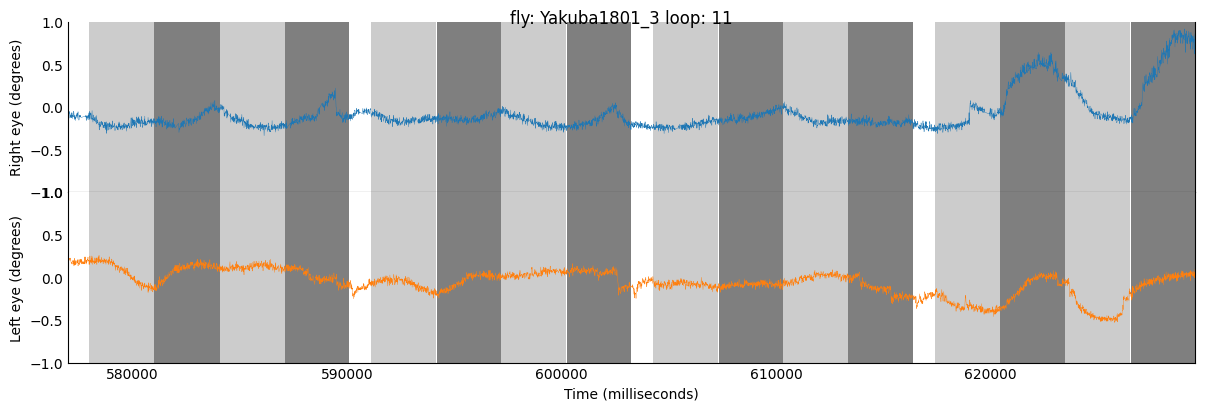

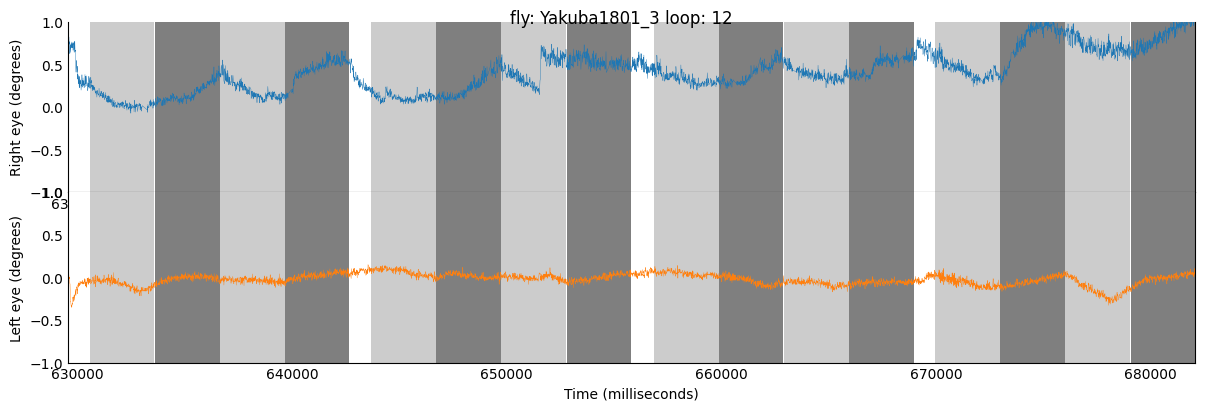

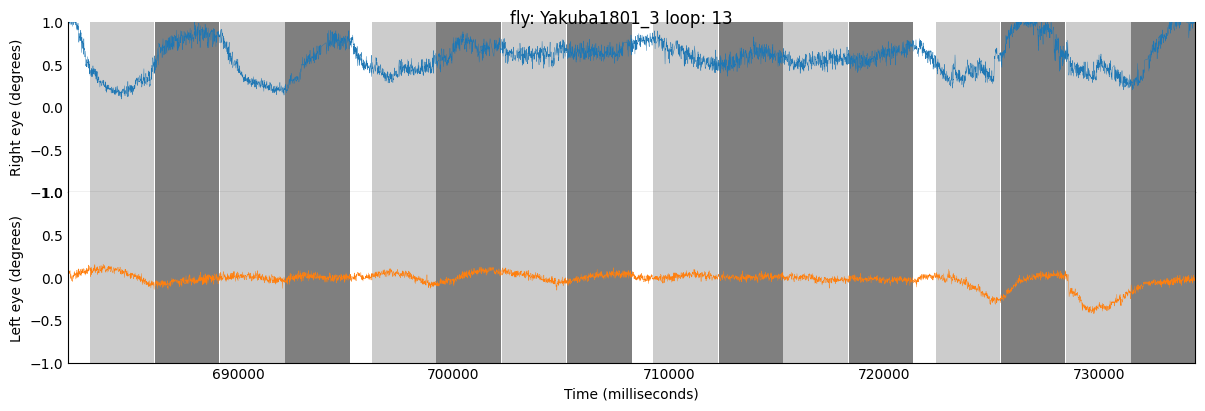

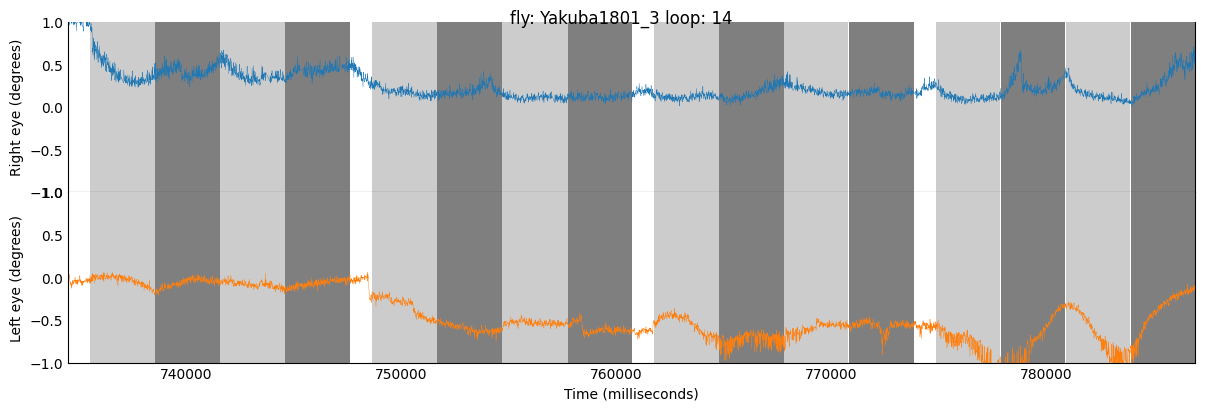

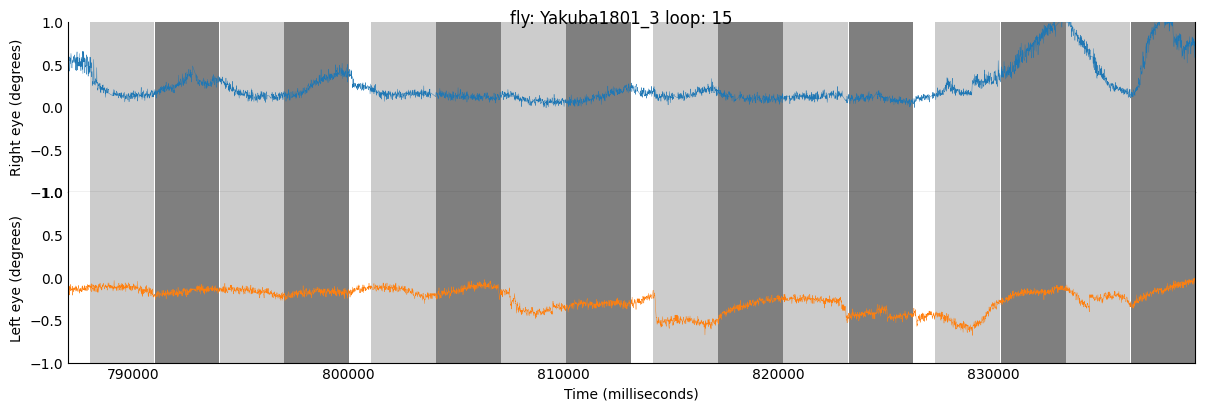

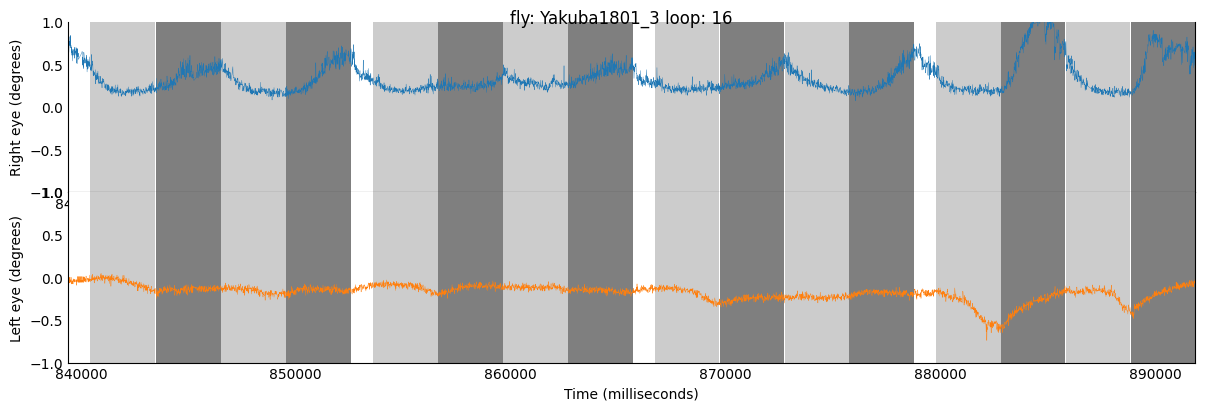

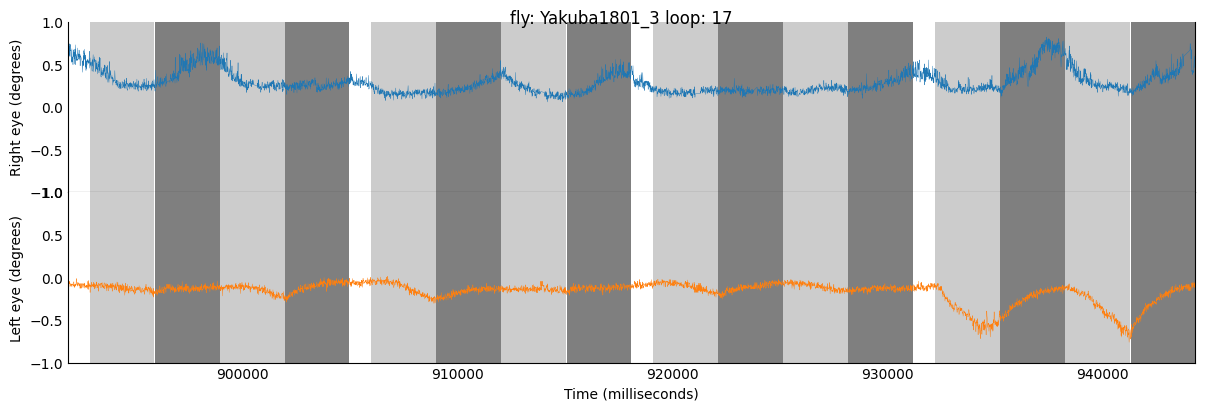

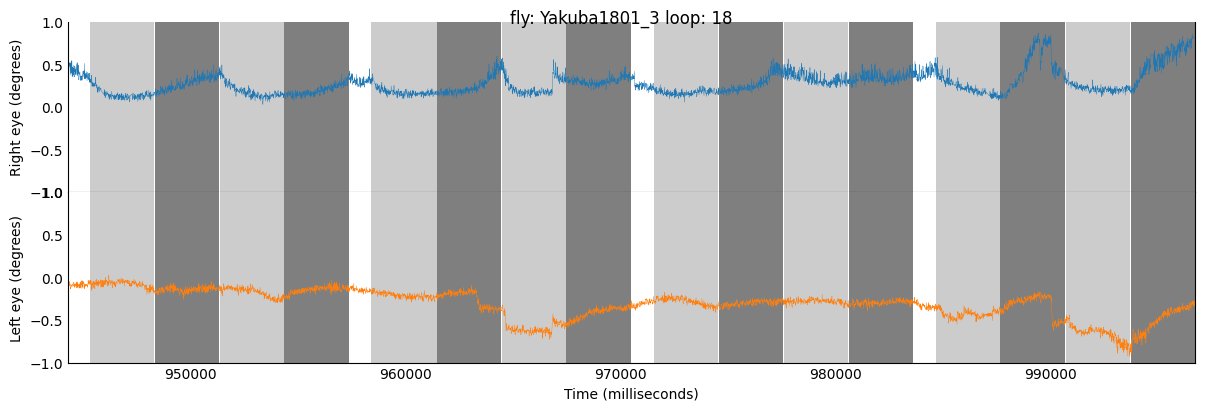

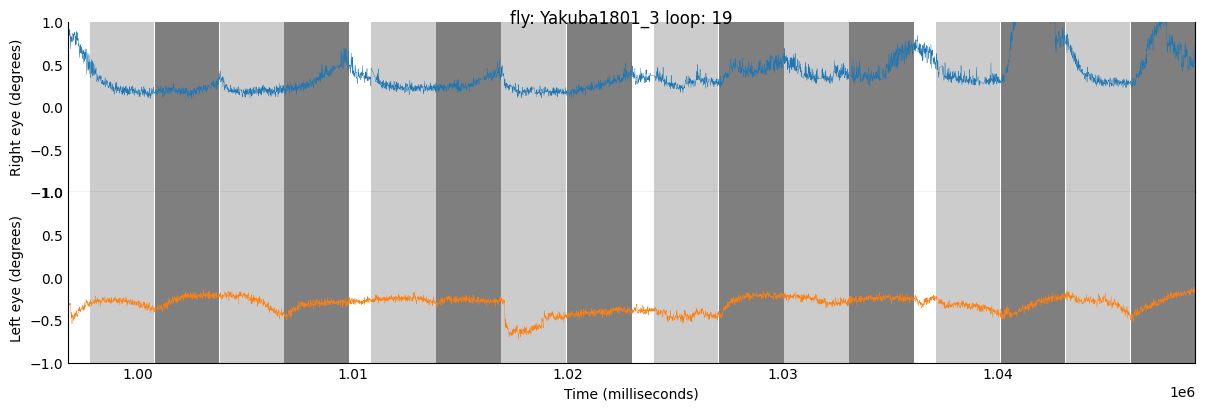

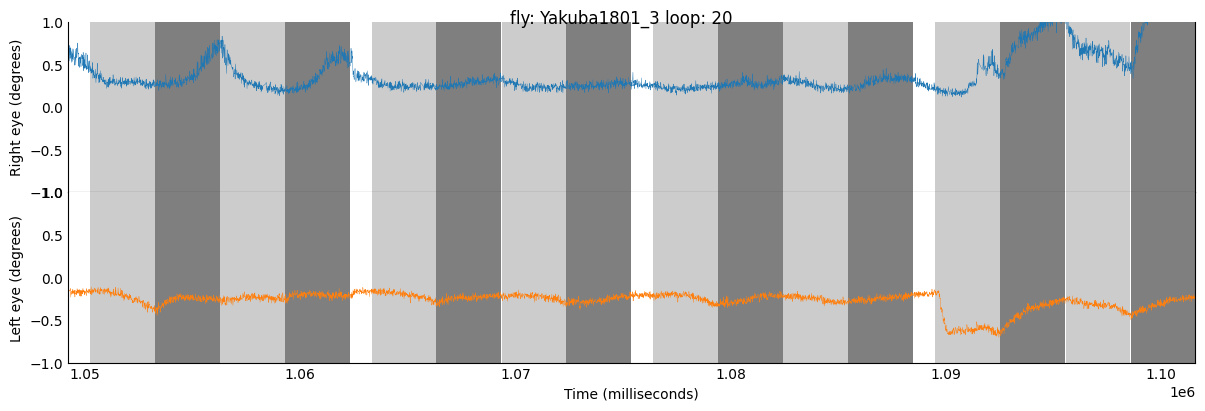

In [32]:
focused_flies = ["Yakuba1801_3"]
#focused_flies = fly_ids
save = True

focused_phases = phases
focused_loops = loops

def config_subplot(subplot, fly, ylabel=None, xlabel=None, xlim=None, ylim = None):
    subplot.set_ylabel(ylabel)
    subplot.tick_params(axis='y')
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(True)
    subplot.spines['left'].set_visible(True)
    subplot.tick_params(axis='both', which='both', length=0)
    if xlabel is None:
        subplot.set_xticks([])
        subplot.spines['bottom'].set_visible(False)
    else:
        subplot.set_xlabel(xlabel)
    if ylim is not None:
        subplot.set_ylim(ylim[0], ylim[1])
    if xlim is not None:
        subplot.set_xlim(xlim[0], xlim[1])
        
    for index, side in df_Stimulus[fly][(df_Stimulus[fly]['Event'] == 'side')].iterrows():
        alpha = 0.2 if side['ID']%2 == 0 else 0.5
        subplot.axvspan(side['Start_ms'], side['End_ms'], facecolor='0', alpha=alpha, zorder=-100)

# Define the y-axis limits for df_RE
ylim = [-1,1]

for fly in focused_flies:
    loops_events = df_Stimulus[fly][df_Stimulus[fly]['Event'] == 'loop']
    for loop in focused_loops:
        loop_data = loops_events[loops_events['ID'] == loop].iloc[0]
        time_start = loop_data['Start_ms']
        time_end = loop_data['End_ms']
        
        # Create a figure with four vertically stacked subplots
        fig, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=False)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0)
        
        i = 0
        config_subplot(axs[i], fly, ylabel='Right eye (degrees)' , xlabel='Time (milliseconds)', xlim=[time_start, time_end], ylim=ylim)
        axs[i].plot(df_RE[fly]['time_stimuli'], df_RE[fly]['omm_x'], label='omm_x', color='tab:blue', linewidth=0.3)
        
        i = 1
        config_subplot(axs[i], fly, ylabel='Left eye (degrees)' , xlabel='Time (milliseconds)', xlim=[time_start, time_end], ylim=ylim)
        axs[i].plot(df_LE[fly]['time_stimuli'], df_LE[fly]['omm_x'], label='omm_x', color='tab:orange', linewidth=0.3)
        
        plt.suptitle(f'fly: {fly} loop: {loop}')
        
        if(save):
            plt.savefig(os.path.join(plot_directory,f'{fly}_loop{loop}.png'), format='png')
        
        # Show the plot
        plt.show()


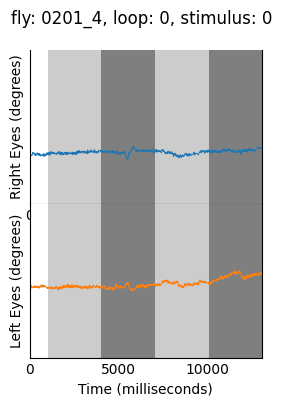

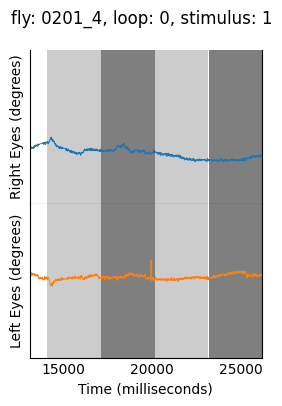

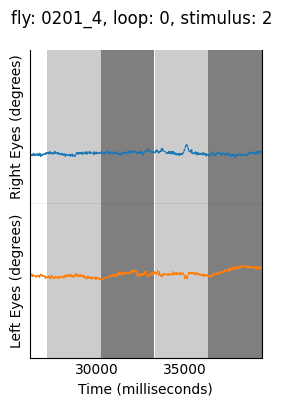

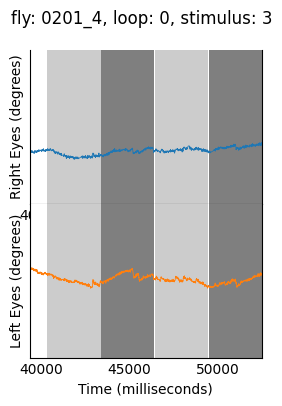

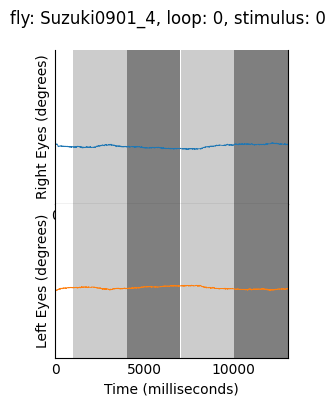

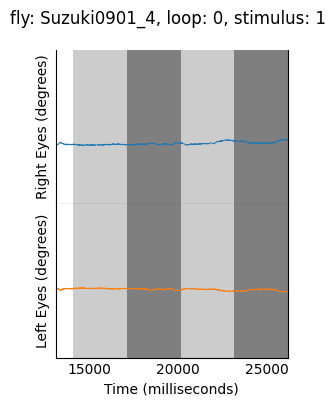

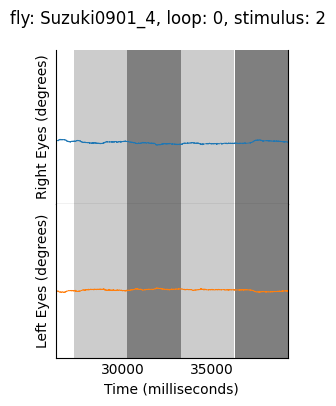

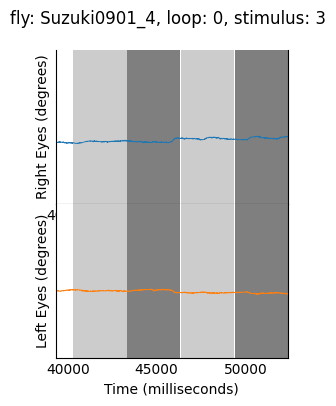

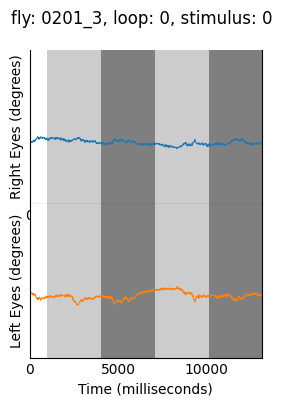

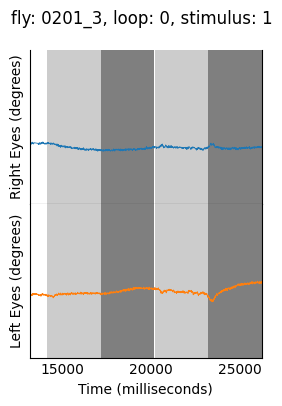

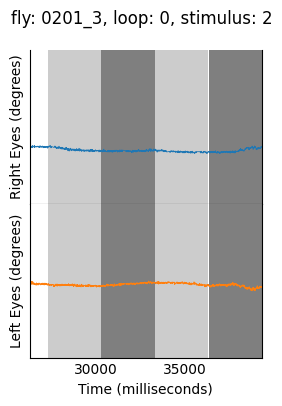

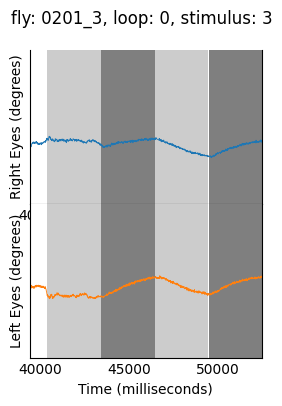

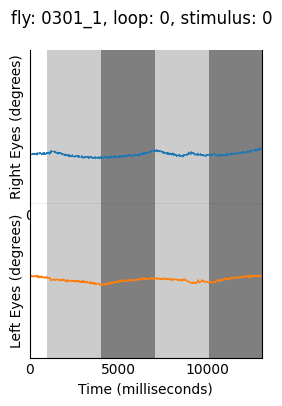

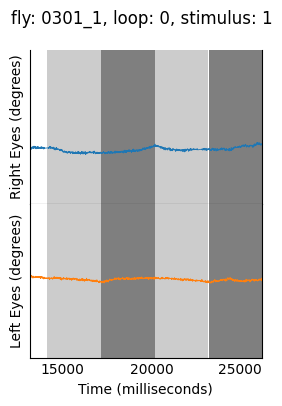

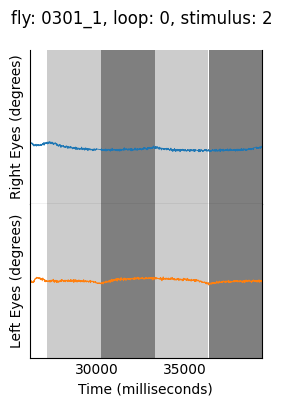

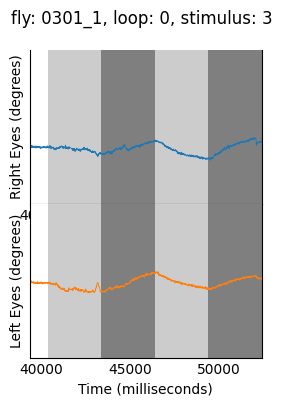

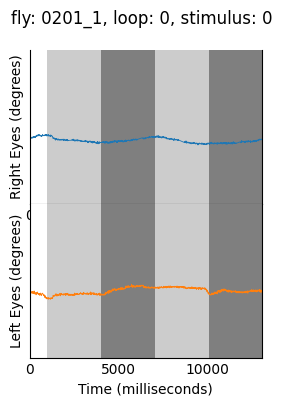

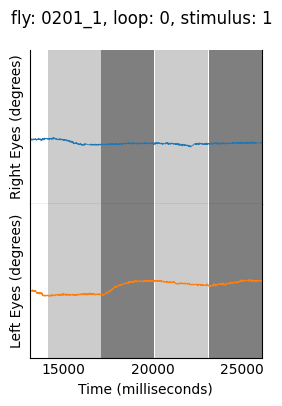

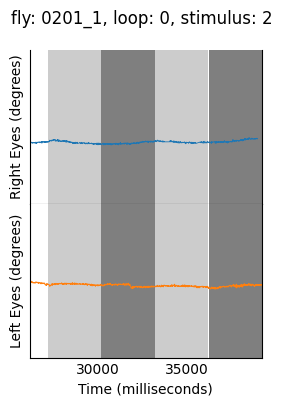

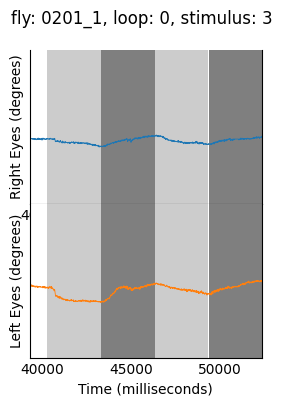

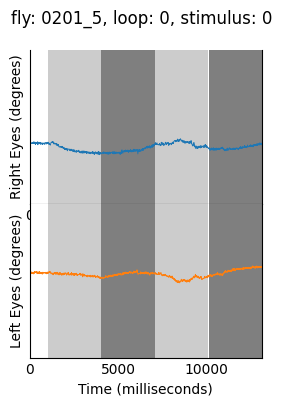

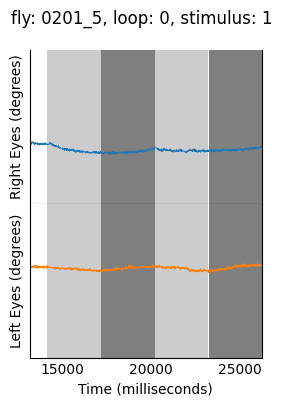

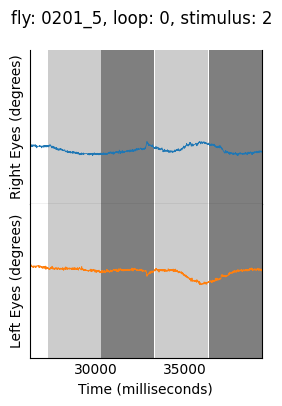

KeyboardInterrupt: 

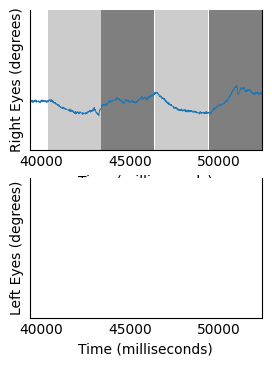

In [6]:
#focused_flies = ["0201_3"]
focused_flies = fly_ids

focused_phases = phases
focused_loops = loops
save = True

# Define the y-axis limits for df_RE
y_min, y_max = -3, 4

for fly in focused_flies:
    loops_events = df_Stimulus[fly][df_Stimulus[fly]['Event'] == 'loop']
    phase_events = df_Stimulus[fly][df_Stimulus[fly]['Event'] == 'phase']
    for loop in focused_loops:
        loop_data = loops_events[loops_events['ID'] == loop].iloc[0]
        loop_start = loop_data['Start_ms']
        loop_end = loop_data['End_ms']
        phases_in_loop = phase_events[(phase_events['Start_ms'] >= loop_start) & (phase_events['End_ms'] <= loop_end)]
        for phase in focused_phases:
            phase_data = phases_in_loop[phases_in_loop['ID'] == phase].iloc[0]
            time_start = phase_data['Start_ms']
            time_end = phase_data['End_ms']
            
            fig, axs = plt.subplots(2, 1, figsize=(3, 4), sharex=False)
            i =0
            config_subplot(axs[i], fly, ylabel='Right Eyes (degrees)', xlabel='Time (milliseconds)', xlim=[time_start, time_end], ylim=[y_min, y_max])
            stimulus_RE_df = df_RE[fly].loc[(df_RE[fly]['stimuli_phase'] == phase) & (df_RE[fly]['stimuli_loop'] == loop)]
            axs[i].plot(stimulus_RE_df['time_stimuli'], stimulus_RE_df['omm_x'], label='omm_x', color='tab:blue', linewidth=0.6)
            
            i =1
            config_subplot(axs[i], fly, ylabel='Left Eyes (degrees)', xlabel='Time (milliseconds)', xlim=[time_start, time_end], ylim=[y_min, y_max])
            stimulus_LE_df = df_LE[fly].loc[(df_LE[fly]['stimuli_phase'] == phase) & (df_LE[fly]['stimuli_loop'] == loop)]
            axs[i].plot(stimulus_LE_df['time_stimuli'], stimulus_LE_df['omm_x'], label='omm_x', color='tab:orange', linewidth=0.6)
            
            # Set title for the entire figure
            plt.suptitle(f'fly: {fly}, loop: {loop}, stimulus: {phase}')
            # Adjust spacing between subplots
            plt.subplots_adjust(hspace=0)
        
            if(save):
                plt.savefig(os.path.join(plot_directory,f'{fly}_loop{loop}_stimulus{phase}.png'), format='png')
            
            plt.show()
